In [2]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as t_dist
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 1

In [3]:
def generate_X(n, rho, rng):
    cov = np.array([[1, rho], [rho, 1]])
    X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n)
    return X[:, 0], X[:, 1]

def generate_Y(X1, X2, beta1, beta2, sigma2, rng):
    e = rng.normal(0, np.sqrt(sigma2), size=len(X1))
    return beta1 * X1 + beta2 * X2 + e

def t_ci(beta_hat, se, df, alpha):
    tcrit = t_dist.ppf(1 - alpha/2, df)
    return beta_hat - tcrit * se, beta_hat + tcrit * se

def algorithm_1(X1, X2, y, alpha):
    n = len(y)

    # model S: y ~ X1
    XS = X1.reshape(n, 1)
    resS = sm.OLS(y, XS).fit()
    beta1_S = resS.params[0]
    se1_S = resS.bse[0]
    df_S = resS.df_resid
    ci1_S = t_ci(beta1_S, se1_S, df_S, alpha)

    # model 3: y ~ X1 + X2
    X3 = np.column_stack([X1, X2])
    res3 = sm.OLS(y, X3).fit()
    beta1_3 = res3.params[0]
    se1_3 = res3.bse[0]
    df_3 = res3.df_resid
    ci1_3 = t_ci(beta1_3, se1_3, df_3, alpha)

    p_b2 = res3.pvalues[1]

    if p_b2 < alpha:
        # select full model
        return beta1_3, ci1_3
    else:
        # select reduced model
        return beta1_S, ci1_S

In [4]:
N = 2000
n = 60
beta1 = 1
sigma2 = 0.25
alpha = 0.05
rhos = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.99])
beta2s = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])

In [19]:
rng = np.random.default_rng(0)
bias = np.zeros((len(rhos), len(beta2s)))
bias_ci_low = np.zeros_like(bias)
bias_ci_high = np.zeros_like(bias)
coverage_prob = np.zeros((len(rhos), len(beta2s)))
coverage_prob_ci_low = np.zeros_like(coverage_prob)
coverage_prob_ci_high = np.zeros_like(coverage_prob)

z = 1.96

with tqdm(total=len(rhos) * len(beta2s), desc="Simulations") as pbar:
    for i, rho in enumerate(rhos):
        for j, beta2 in enumerate(beta2s):
            beta1_hats_diff = np.empty(N)
            coverage_probs = np.empty(N)

            for r in range(N):
                X1, X2 = generate_X(n, rho, rng)
                y = generate_Y(X1, X2, beta1, beta2, sigma2, rng)
                beta1_hat, ci = algorithm_1(X1, X2, y, alpha)
                beta1_hats_diff[r] = beta1_hat - beta1
                coverage_probs[r] = (ci[0] <= beta1 <= ci[1])

            bias[i, j] = np.mean(beta1_hats_diff)
            se_b = np.std(beta1_hats_diff, ddof=1) / np.sqrt(N)
            bias_ci_low[i, j] = bias[i, j] - z * se_b
            bias_ci_high[i, j] = bias[i, j] + z * se_b

            coverage_prob[i, j] = np.mean(coverage_probs)
            se_cp = np.sqrt(coverage_prob[i, j] * (1 - coverage_prob[i, j]) / N)
            coverage_prob_ci_low[i, j] = coverage_prob[i, j] - z * se_cp
            coverage_prob_ci_high[i, j] = coverage_prob[i, j] + z * se_cp
            pbar.update(1)

Simulations: 100%|██████████| 78/78 [02:43<00:00,  2.10s/it]


## a

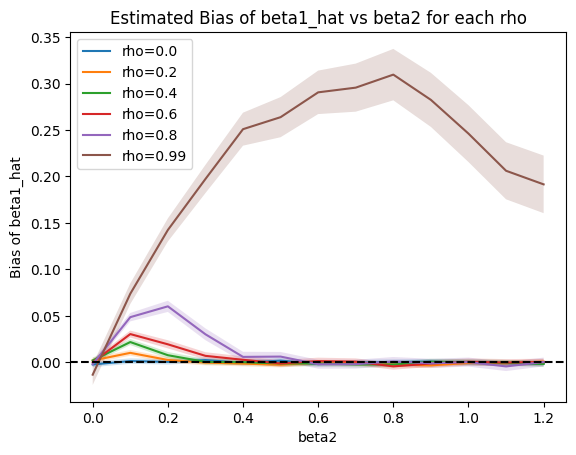

In [22]:
for i, rho in enumerate(rhos):
    plt.plot(beta2s, bias[i], label=f"rho={rho}")
    plt.fill_between(beta2s, bias_ci_low[i], bias_ci_high[i], alpha=0.2)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("beta2")
plt.ylabel("Bias of beta1_hat")
plt.title("Estimated Bias of beta1_hat vs beta2 for each rho")
plt.legend()
plt.show()

In [27]:
sig = (bias_ci_low > 0) | (bias_ci_high < 0)

print("Bias statistically significant (CI does not contain 0):")
for i, rho in enumerate(rhos):
    idx = np.where(sig[i])[0]

    if len(idx) == 0:
        continue
    
    ranges = []
    start = idx[0]
    prev = idx[0]
    for k in idx[1:]:
        if k == prev + 1:
            prev = k
        else:
            ranges.append((beta2s[start], beta2s[prev]))
            start = k
            prev = k
    ranges.append((beta2s[start], beta2s[prev]))
    pretty_print = ", ".join([f"{a:.2f}-{b:.2f}" if a != b else f"{a:.2f}" for a, b in ranges])
    print(f"rho={rho}: beta2 in {pretty_print}")

Bias statistically significant (CI does not contain 0):
rho=0.2: beta2 in 0.10, 0.90
rho=0.4: beta2 in 0.10-0.20
rho=0.6: beta2 in 0.10-0.30, 0.80
rho=0.8: beta2 in 0.10-0.50
rho=0.99: beta2 in 0.00-1.20


## b

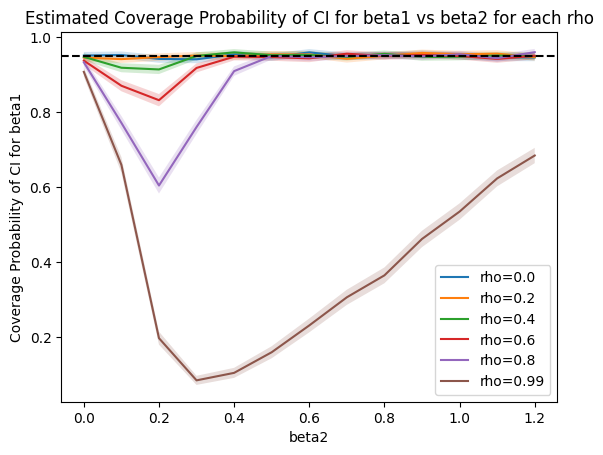

In [23]:
for i, rho in enumerate(rhos):
    plt.plot(beta2s, coverage_prob[i], label=f"rho={rho}")
    plt.fill_between(beta2s, coverage_prob_ci_low[i], coverage_prob_ci_high[i], alpha=0.2)
plt.axhline(1 - alpha, color='black', linestyle='--')
plt.xlabel("beta2")
plt.ylabel("Coverage Probability of CI for beta1")
plt.title("Estimated Coverage Probability of CI for beta1 vs beta2 for each rho")
plt.legend()
plt.show()

The simulation results show that empirical coverage remains close to nominal
95% level when the correlation between regressors is low, but deteriorates 
extremely as correlation increases. When $\rho$ is small (0, 0.2), omitting $X_2$ 
does not introduce substantial bias in $\hat{\beta}_1$. However, as $\rho$ increases
to values such as 0.4 and 0.6, $\beta_2$ becomes large enough to impact the model,
but not always large enough to always be selected. Thus, bias is only introduced
when the "short" model is selected. We can see the issue worsen as $\rho$ gets 
extremely large (0.8, 0.99), and undercoverage becomes severe. The effect is
lessened however as $\beta_2$ grows large at large $\rho$, the full model is
always selected and coverage returns toward the nominal level. 

## c

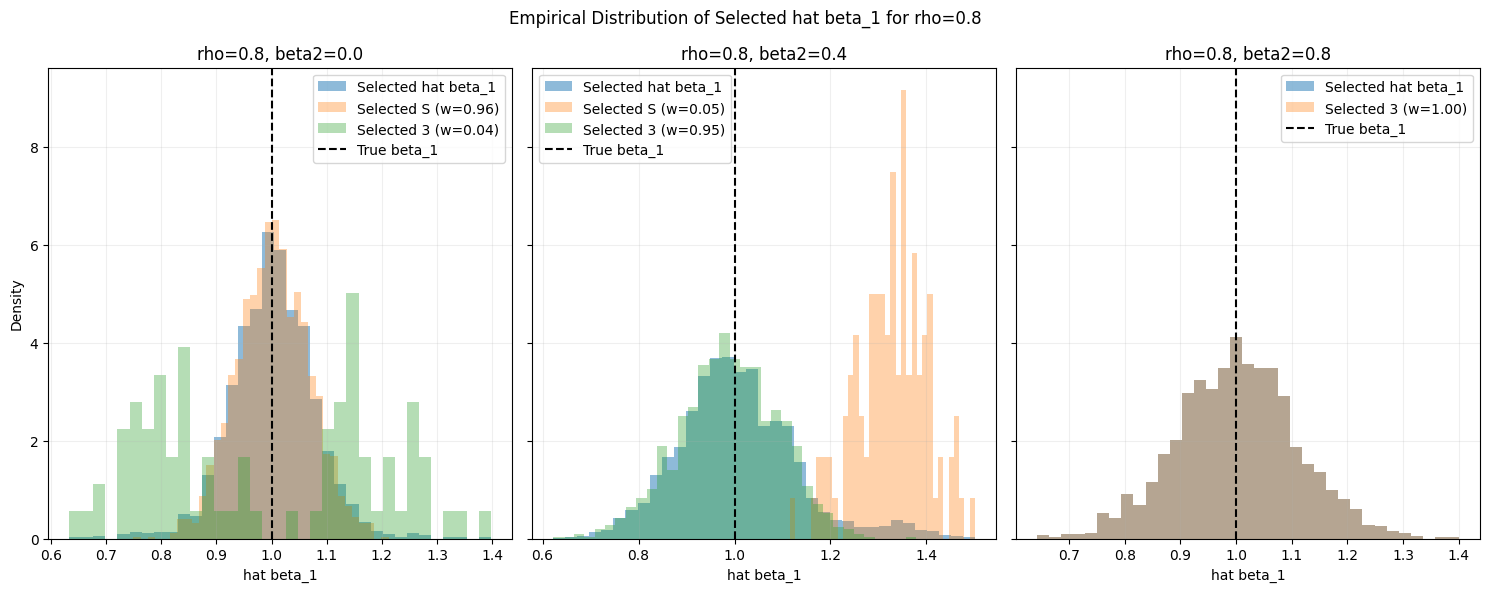

In [37]:
rho = 0.8
beta2s = np.array([0.0, 0.4, 0.8])

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, beta2 in zip(axes, beta2s):
    b1_hat = np.empty(N)
    b1_S = np.empty(N)
    b1_3 = np.empty(N)
    sel3 = np.zeros(N, dtype=bool)

    for r in range(N):
        X1, X2 = generate_X(n, rho, rng)
        y = generate_Y(X1, X2, beta1, beta2, sigma2, rng)

        # model S
        XS = X1.reshape(n, 1)
        resS = sm.OLS(y, XS).fit()
        b1_S[r] = resS.params[0]

        # model 3
        X3 = np.column_stack([X1, X2])
        res3 = sm.OLS(y, X3).fit()
        b1_3[r] = res3.params[0]
        sel3[r] = (res3.pvalues[1] < alpha)

        # selected model
        b1_hat[r] = b1_3[r] if sel3[r] else b1_S[r]

    w3 = sel3.mean()
    wS = 1 - w3

    bins = 35
    ax.hist(b1_hat, bins=bins, density=True, alpha=0.5, edgecolor="none", label="Selected hat beta_1")

    if wS > 0:
        ax.hist(b1_hat[~sel3], bins=bins, density=True, alpha=0.35, edgecolor="none", label=f"Selected S (w={wS:.2f})")
    
    if w3 > 0:
        ax.hist(b1_hat[sel3], bins=bins, density=True, alpha=0.35, edgecolor="none", label=f"Selected 3 (w={w3:.2f})")

    ax.axvline(beta1, color='black', linestyle='--', label="True beta_1")
    ax.set_title(f"rho={rho}, beta2={beta2}")
    ax.set_xlabel("hat beta_1")
    ax.legend()
    ax.grid(True, alpha=0.2)

axes[0].set_ylabel("Density")
plt.suptitle("Empirical Distribution of Selected hat beta_1 for rho=0.8")
plt.tight_layout()
plt.show()

The selected estimator from algorithm 1 is literally model 3 if the t-test
rejects the null hypothesis of beta2 = 0 (if p < $\alpha$), otherwise it selects
model 1. Thus, its sampling distribution is a mixture of the two distributions
where the mixture weight is the probability that p < $\alpha$, and in the simulation
is estimated by the selection frequency `sel3.mean()`. Consequently, this weight
increases when $\beta_2$ is larger, which we can see occur as $\beta_2$ increases.
We can see that when $\beta_2 = 0$, the full model is only selected around 4% of
the time so $\hat{\beta}_1$ is almot entirely the reduced model estimator. With
$\beta_2 = 0.4$, selection is unstable and heavily tilted towards the full model.
However, the reduced model estimator has omitted variable bias, which is why we
see a noticeable different peak in the distribution compared to the roughly
normal distributions of the previous graph. Lastly, when $\beta_2 = 0.8$, the full
model is always selected, thus the mixture collpases to a single component
and the distribution is roughly normal around $\beta_1$.

## d

It seems counterintuitive as in the full model OLS for $\beta_1$ is unbiased
regardless of whether $\beta_2$ is zero or not. The bias comes from the selection
step, as the expectation is:
$$
E[\hat{\beta}_1] = wE[\hat{\beta}_1^{(3)}] + (1 - w)E[\hat{\beta}_1^{(S)}]
$$
The full model estimator is unbiased as $E[\hat{\beta}_1^{(3)}] = \beta_1$, but
the reduced model suffers omitted variable bias as $E[\hat{\beta}_1^{(S)}] = \beta_1 + \beta_2\rho$.
Thus, the expectation is:
$$
E[\hat{\beta}_1] = \beta_1 + (1 - w)\beta_2\rho
$$
and the bias is consequently:
$$
\text{Bias}(\hat{\beta}_1) = (1 - w)\beta_2\rho
$$

Thus, we can see how the mixture argument from part c applies here, as the bias
stems from mixing an unbiased estimator (full) with the a biased one (reduced),
where the mixing weight depends onthe magnitude of $\beta_2$.

# 2

In [8]:
N = 20000
n = 60
beta1 = 1
beta2 = 0.25
sigma2 = 0.25

## a

In [15]:
rhos = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.99])
holdout_ratio = 0.2

def mspe_model_s(n, rho, beta1, beta2, sigma2, holdout_ratio, rng):
    X1, X2 = generate_X(n, rho, rng)
    y = generate_Y(X1, X2, beta1, beta2, sigma2, rng)

    idx = rng.permutation(n)
    n_test = int(n * holdout_ratio)
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]

    X1_tr, X1_ho = X1[train_idx], X1[test_idx]
    y_tr, y_ho = y[train_idx], y[test_idx]

    model = sm.OLS(y_tr, X1_tr).fit()
    beta1_hat = model.params[0]
    yhat_te = beta1_hat * X1_ho
    mspe_S = np.mean((y_ho - yhat_te) ** 2)

    return mspe_S

rng = np.random.default_rng(0)
mspe_Ss = np.empty(len(rhos))
mspe_ci_low = np.empty_like(mspe_Ss)
mspe_ci_high = np.empty_like(mspe_Ss)
theoretical_mspe_S = np.empty_like(mspe_Ss)

z = 1.96

n_test = int(n * holdout_ratio)
D_size = n - n_test

for i, rho in enumerate(tqdm(rhos, desc="MSPE Simulations")):
    mspe_S_vals = np.empty(N)

    for r in range(N):
        mspe_S_vals[r] = mspe_model_s(n, rho, beta1, beta2, sigma2, holdout_ratio, rng)

    mspe_Ss[i] = np.mean(mspe_S_vals)
    se_mspe = np.std(mspe_S_vals, ddof=1) / np.sqrt(N)
    mspe_ci_low[i] = mspe_Ss[i] - z * se_mspe
    mspe_ci_high[i] = mspe_Ss[i] + z * se_mspe

    theoretical_mspe_S[i] = (1 + 1 / (D_size - 2)) * (sigma2 + beta2**2 * (1 - rho**2))

MSPE Simulations: 100%|██████████| 6/6 [00:22<00:00,  3.76s/it]


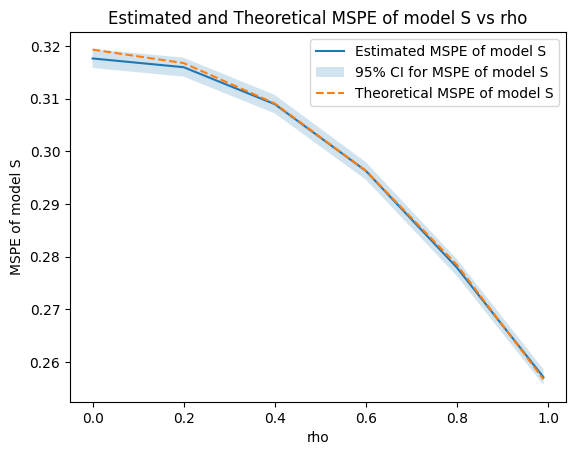

In [16]:
plt.plot(rhos, mspe_Ss, label="Estimated MSPE of model S")
plt.fill_between(rhos, mspe_ci_low, mspe_ci_high, alpha=0.2, label="95% CI for MSPE of model S")
plt.plot(rhos, theoretical_mspe_S, label="Theoretical MSPE of model S", linestyle='--')
plt.xlabel("rho")
plt.ylabel("MSPE of model S")
plt.title("Estimated and Theoretical MSPE of model S vs rho")
plt.legend()
plt.show()

## b

In [12]:
rho = 0.5
holdout_ratios = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

mspe_Ss = np.empty(len(holdout_ratios))
mspe_ci_low = np.empty_like(mspe_Ss)
mspe_ci_high = np.empty_like(mspe_Ss)
theoretical_mspe_S = np.empty_like(mspe_Ss)

for i, holdout_ratio in enumerate(tqdm(holdout_ratios, desc="Holdout Ratio Simulations")):
    mspe_S_vals = np.empty(N)

    for r in range(N):
        mspe_S_vals[r] = mspe_model_s(n, rho, beta1, beta2, sigma2, holdout_ratio, rng)

    mspe_Ss[i] = np.mean(mspe_S_vals)
    se_mspe = np.std(mspe_S_vals, ddof=1) / np.sqrt(N)
    mspe_ci_low[i] = mspe_Ss[i] - z * se_mspe
    mspe_ci_high[i] = mspe_Ss[i] + z * se_mspe

    D_size = n - int(n * holdout_ratio)
    theoretical_mspe_S[i] = (1 + 1 / (D_size - 2)) * (sigma2 + beta2**2 * (1 - rho**2))

Holdout Ratio Simulations: 100%|██████████| 9/9 [00:34<00:00,  3.78s/it]


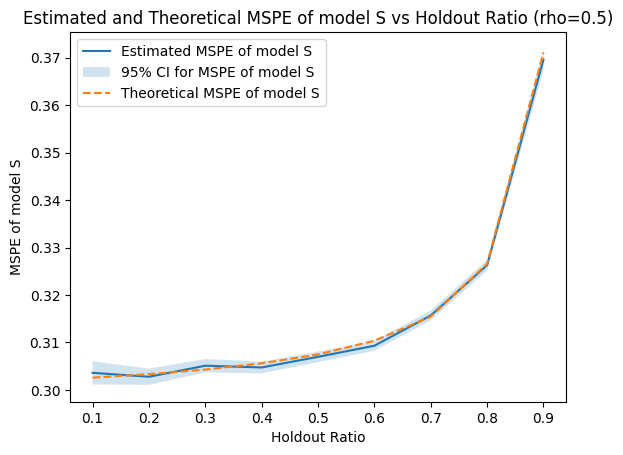

In [13]:
plt.plot(holdout_ratios, mspe_Ss, label="Estimated MSPE of model S")
plt.fill_between(holdout_ratios, mspe_ci_low, mspe_ci_high, alpha=0.2, label="95% CI for MSPE of model S")
plt.plot(holdout_ratios, theoretical_mspe_S, label="Theoretical MSPE of model S", linestyle='--')
plt.xlabel("Holdout Ratio")
plt.ylabel("MSPE of model S")
plt.title("Estimated and Theoretical MSPE of model S vs Holdout Ratio (rho=0.5)")
plt.legend()
plt.show()

Based on the plot, we clearly want the lowest possible MSPE, so we select
`r = 0.2`. This also makes sense mathematically as in general, as `r` grows,
we reduce the training smaple size $|D|$, which increases the estimation variance
and consequently worsens the predictive performance. `r = 0.2` gives a low MSPE
while maintaining a reasonable test set size.

## c

In [17]:
rho = 0.5
holdout_ratio = 0.2
K = np.array([2, 3, 6, 10, 20, 30])

mspe_Ss = np.empty(len(K))
mspe_ci_low = np.empty_like(mspe_Ss)
mspe_ci_high = np.empty_like(mspe_Ss)
theoretical_mspe_S = np.empty_like(mspe_Ss)

def kfold_mspe_S(n, rho, beta1, beta2, sigma2, K_val, rng):
    X1, X2 = generate_X(n, rho, rng)
    y = generate_Y(X1, X2, beta1, beta2, sigma2, rng)

    idx = rng.permutation(n)
    folds = np.array_split(idx, K_val)

    mses = []
    for test_idx in folds:
        train_idx = np.setdiff1d(idx, test_idx, assume_unique=True)
        X1_tr, X1_te = X1[train_idx], X1[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        model = sm.OLS(y_tr, X1_tr).fit()
        beta1_hat = model.params[0]
        yhat_te = beta1_hat * X1_te
        mse_S = np.mean((y_te - yhat_te) ** 2)
        mses.append(mse_S)

    return np.mean(mses)

for i, K_val in enumerate(tqdm(K, desc="K Simulations")):
    mspe_S_vals = np.empty(N)

    for r in range(N):
        mspe_S_vals[r] = kfold_mspe_S(n, rho, beta1, beta2, sigma2, K_val, rng)

    mspe_Ss[i] = np.mean(mspe_S_vals)
    se_mspe = np.std(mspe_S_vals, ddof=1) / np.sqrt(N)
    mspe_ci_low[i] = mspe_Ss[i] - z * se_mspe
    mspe_ci_high[i] = mspe_Ss[i] + z * se_mspe

    D_size = int(round(n * (K_val - 1) / K_val))
    theoretical_mspe_S[i] = (1 + 1 / (D_size - 2)) * (sigma2 + beta2**2 * (1 - rho**2))

K Simulations: 100%|██████████| 6/6 [03:29<00:00, 34.84s/it]


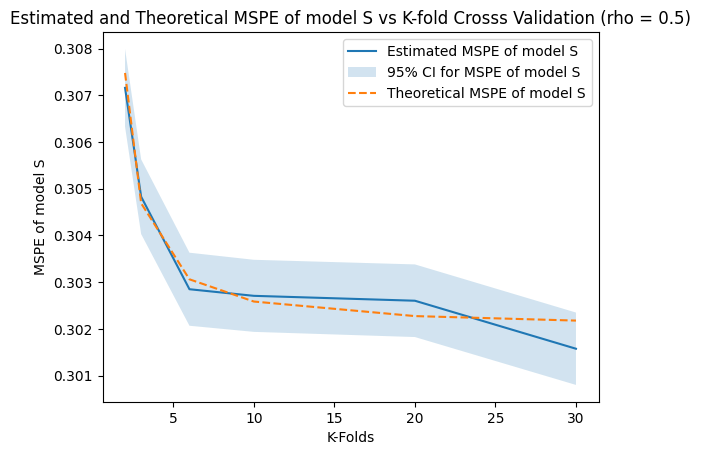

In [18]:
plt.plot(K, mspe_Ss, label="Estimated MSPE of model S")
plt.fill_between(K, mspe_ci_low, mspe_ci_high, alpha=0.2, label="95% CI for MSPE of model S")
plt.plot(K, theoretical_mspe_S, label="Theoretical MSPE of model S", linestyle='--')
plt.xlabel("K-Folds")
plt.ylabel("MSPE of model S")
plt.title("Estimated and Theoretical MSPE of model S vs K-fold Crosss Validation (rho = 0.5)")
plt.legend()
plt.show()

We can approach choosing a good K from an elbow plot perspective. Note that the
reduction in MSPE while pushing K from 6 to 10 to 20 to 30 are minimal at best.
Likewise, with the tqdm loop and logically, we know that increasing K results
in K times more simulations to perform (as we have K many folds), thus a higher
K requires more computation time and resources. Consequently, while K = 30 gives
the lowest MSPE and is numerically optimal, the practical optimal K would be
6 as we still obtain a reasonably low MSPE but with much better computation performance.
We also notice that the CI band width increases slightly as K grows, which is 
expected as it reflects the higher variability in the cross validation estimator.
This shows the inherent bias-variance tradeoff, as individual fold MSE estimates
become noisier and more correlated acros folds, increase the variance. Similarly,
for this reason, we still prefer the lower K value of 6 as we have a reasonaable
balance in bias and low variance.

**LLM Usage**: All work was done by myself in VSCode with [GitHub Copilot integration](https://code.visualstudio.com/docs/copilot/overview). The integration "provides code suggestions, explanations, and automated implementations based on natural language prompts and existing code context," and also offers autonomous coding and an in-IDE chat interface that is able to interact with the current codebase. Only the Copilot provided automatic inline suggestions for both LaTex and Python in `.tex` and `.ipynb` Jupyter notebook files respectively were taken into account / used.

**Problem 1**:  
a) LLM was used to help structure code to run efficiently for both parts (a) and (b)
at the same time. LLM was also consulted to see how to run 20000 simulations efficiently,
but ultimately I chose to reduce the N to 2000 as suggested in Piazza to avoid
making messier matrix math.  
b) LLM was used to help understand how $\beta_2$ and $X_2$ dropout occurs.  
c) LLM was used to help overlay plots for better design.  
d) LLM was used to help understand the omitted variable bias and how it plays
into the mixture argument.  

**Problem 2**:  
a) LLM was used to help generate indexing needed for random holdout.  
b) LLM was not used in this problem.  
c) LLM was used to help generate K folds indexing needed for cross validation.  

Despite these usages, LLM was not used to fully compute answers.